# Named-Entity-Recognition with the MIT movie database

**Dataset**: https://groups.csail.mit.edu/sls/downloads/movie/  
**Problem**: Train a model which can tokenize sentences and extract named entities  
**Validation**: Evaluate the model with train and test samples  
**Application or exercise**: Use another data to validate the model

**Guidelines**:
- [x] Get the data
- [x] Understand the data's context and format
- [x] Understand the problem
- [x] Propose a solution
- [x] Validate the model
- [x] Look for some data with similar context and use it to evaluate the model

## Libraries

In [43]:
from nltk import word_tokenize, pos_tag
from nltk.chunk import conlltags2tree, tree2conlltags, ChunkParserI
from nltk.stem.snowball import SnowballStemmer
from nltk.tag import ClassifierBasedTagger
from nltk.chunk.util import ChunkScore

import pandas as pd
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import CountVectorizer
from yellowbrick.text import FreqDistVisualizer
from yellowbrick.text import PosTagVisualizer

from collections import Iterable
import re
import requests
import unicodedata
from xml.sax.saxutils import unescape

import os
import warnings

warnings.filterwarnings("always")

## Get the data

In [2]:
def make_dirs(dirs_list=["data"]):
    for item in dirs_list:
        if os.path.exists(item):
            pass
        else:
            os.mkdir(item)

make_dirs()

In [3]:
!wget -P ./data https://groups.csail.mit.edu/sls/downloads/movie/engtest.bio
!wget -P ./data https://groups.csail.mit.edu/sls/downloads/movie/engtrain.bio
!wget -P ./data https://groups.csail.mit.edu/sls/downloads/movie/trivia10k13test.bio
!wget -P ./data https://groups.csail.mit.edu/sls/downloads/movie/trivia10k13train.bio

--2020-07-12 17:26:35--  https://groups.csail.mit.edu/sls/downloads/movie/engtest.bio
Resolving groups.csail.mit.edu (groups.csail.mit.edu)... 128.30.2.44
Connecting to groups.csail.mit.edu (groups.csail.mit.edu)|128.30.2.44|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 252636 (247K)
Saving to: ‘./data/engtest.bio’

engtest.bio         100%[===================>] 246.71K   174KB/s    in 1.4s    

2020-07-12 17:26:37 (174 KB/s) - ‘./data/engtest.bio’ saved [252636/252636]

--2020-07-12 17:26:37--  https://groups.csail.mit.edu/sls/downloads/movie/engtrain.bio
Resolving groups.csail.mit.edu (groups.csail.mit.edu)... 128.30.2.44
Connecting to groups.csail.mit.edu (groups.csail.mit.edu)|128.30.2.44|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1013492 (990K)
Saving to: ‘./data/engtrain.bio’

engtrain.bio        100%[===================>] 989.74K   145KB/s    in 6.8s    

2020-07-12 17:26:44 (147 KB/s) - ‘./data/engtrain.bio’ saved [1013

## Understand the data's context and format

The dataset is composed of semantically tagged corpora (train and test sets) in BIO format about the domain `movies`. One corpus is called `eng` and it contains simple queries, while the other corpus, `trivia10k13` have more complex queries.

For the purpose of this test I decided to stick with the `trivia10k13` corpus only. One example of tagged queries is:

B-Actor	steve  
I-Actor	mcqueen  
O	provided  
O	a  
B-Plot	thrilling  
I-Plot	motorcycle  
I-Plot	chase  
I-Plot	in  
I-Plot	this  
B-Opinion	greatest  
I-Opinion	of  
I-Opinion	all  
B-Plot	ww  
I-Plot	2  
I-Plot	prison  
I-Plot	escape  
I-Plot	movies  

This format or tagging system is also called `IOB tagging`. A tagged sentence is works like a tree: 
- The sentence S is the parent node (node zero)
- The sentence is broken into chunks with each chunk belonging to some context. Chunks are the nodes 1 of the tree
- Chunks are broken into tokens which are the nodes 2 of the tree
- The format `B-{chunk_class}` represents the tokens in the begging of the chunk
- The format `I-{chunk_class}` represents the tokens inside the chunk
- Some tokens are not part of a chunk and are tagged with `O`. These will also be in node 1

## Understand the problem

I propose a problem with the following steps: 
- Find the part-of-speech tags (pos_tag) for the sentences
- Build a model which trains with (words, pos_tags, iob_tags)
- After trained the model will receive a sentence as input and the output will be the tree with pos_tags and iob_tags
- The performance will be evaluated with the train and test sets
- An external data (from the opentdb API) will also be used to evaluate the model's performance

## Propose a solution

Since I don't have much time I will not focus in hyper-tuning or try a lot of models. My first ideia is to approach with algorithms from NLTK or spaCy libraries, spaCy usually have good performance but also is kind of more bureaucratic. So for simplicity I chose NLTK. It would be great to add snorkel to this solution, but it would also take more time.

Let me first read the data find the pos_tags. NLTK documentation has a lot of examples of how to to that [here](https://www.nltk.org/book/ch07.html).

For a list of Part-of-Speech (POS) symbols see the reference [Apertium](https://wiki.apertium.org/wiki/List_of_symbols)

### Read data

Sentences are separated by `\n\n`, iob_tags and words by `\t` and (iob_tags,words) pairs by `\n`. This [guy has a good material](https://gist.github.com/bogdan-ivanov/7e0b733ffcf18dfc1fef45d790b8403e), it looks like there are some errors and our data is not in the same format as his but with some fixes will fit perfectly.  
Each of the following readers will have a specific output format.

In [4]:
def read_corpus(file,root="./data"):
    for root, dirs, files in os.walk("./data"):
        for filename in files:
            if filename == file:
                with open(os.path.join(root, filename), 'rb') as file_handle:
                    file_content = file_handle.read().decode('utf-8').strip()
                    annotated_sentences = file_content.split('\n\n')
                    for annotated_sentence in annotated_sentences:
                        annotated_tokens = [seq for seq in annotated_sentence.split('\n') if seq]
                        annotated_tags = pos_tag([seq.split('\t')[-1] for seq in annotated_sentence.split('\n') if seq])
                        conll_tokens = []
                        for annotated_token, annotated_tag in zip(annotated_tokens,annotated_tags):
                            annotations = annotated_token.split('\t')
                            word,iob_tag = annotations[1], annotations[0]
                            tag = annotated_tag[1]   # tag is the same as pos_tag
                            if tag in ('LQU', 'RQU'): # left and right quotes
                                tag = "``"
                            conll_tokens.append((word, tag, iob_tag))
                        yield [((w, t), iob) for w, t, iob in conll_tokens]
                        
def read_corpus_to_pos_tags(file,root="./data"):
    for root, dirs, files in os.walk("./data"):
        for filename in files:
            if filename == file:
                with open(os.path.join(root, filename), 'rb') as file_handle:
                    file_content = file_handle.read().decode('utf-8').strip()
                    annotated_sentences = file_content.split('\n\n')
                    for annotated_sentence in annotated_sentences:
                        annotated_tokens = [seq for seq in annotated_sentence.split('\n') if seq]
                        annotated_tags = pos_tag([seq.split('\t')[-1] for seq in annotated_sentence.split('\n') if seq])
                        conll_tokens = []
                        for annotated_token, annotated_tag in zip(annotated_tokens,annotated_tags):
                            annotations = annotated_token.split('\t')
                            word,iob_tag = annotations[1], annotations[0]
                            tag = annotated_tag[1]
                            if tag in ('LQU', 'RQU'):
                                tag = "``"
                            conll_tokens.append((word, tag, iob_tag))
                        yield [(w, t) for w, t, iob in conll_tokens]

def read_corpus_to_tree(file,root="./data"):
    for root, dirs, files in os.walk("./data"):
        for filename in files:
            if filename == file:
                with open(os.path.join(root, filename), 'rb') as file_handle:
                    file_content = file_handle.read().decode('utf-8').strip()
                    annotated_sentences = file_content.split('\n\n')
                    for annotated_sentence in annotated_sentences:
                        annotated_tokens = [seq for seq in annotated_sentence.split('\n') if seq]
                        annotated_tags = pos_tag([seq.split('\t')[-1] for seq in annotated_sentence.split('\n') if seq])
                        conll_tokens = []
                        for annotated_token, annotated_tag in zip(annotated_tokens,annotated_tags):
                            annotations = annotated_token.split('\t')
                            word,iob_tag = annotations[1], annotations[0]
                            tag = annotated_tag[1]
                            if tag in ('LQU', 'RQU'):
                                tag = "``"
                            conll_tokens.append((word, tag, iob_tag))
                        yield conlltags2tree(conll_tokens)

def read_corpus_to_sentence(file,root="./data"):
    for root, dirs, files in os.walk("./data"):
        for filename in files:
            if filename == file:
                with open(os.path.join(root, filename), 'rb') as file_handle:
                    file_content = file_handle.read().decode('utf-8').strip()
                    annotated_sentences = file_content.split('\n\n')
                    for annotated_sentence in annotated_sentences:
                        annotated_tokens = [seq.split('\t')[-1] for seq in annotated_sentence.split('\n') if seq]

                        yield " ".join(annotated_tokens)

In [5]:
# example 1
next(read_corpus("trivia10k13train.bio"))

[(('steve', 'NN'), 'B-Actor'),
 (('mcqueen', 'NN'), 'I-Actor'),
 (('provided', 'VBD'), 'O'),
 (('a', 'DT'), 'O'),
 (('thrilling', 'JJ'), 'B-Plot'),
 (('motorcycle', 'NN'), 'I-Plot'),
 (('chase', 'NN'), 'I-Plot'),
 (('in', 'IN'), 'I-Plot'),
 (('this', 'DT'), 'I-Plot'),
 (('greatest', 'JJS'), 'B-Opinion'),
 (('of', 'IN'), 'I-Opinion'),
 (('all', 'DT'), 'I-Opinion'),
 (('ww', '$'), 'B-Plot'),
 (('2', 'CD'), 'I-Plot'),
 (('prison', 'NN'), 'I-Plot'),
 (('escape', 'NN'), 'I-Plot'),
 (('movies', 'NNS'), 'I-Plot')]

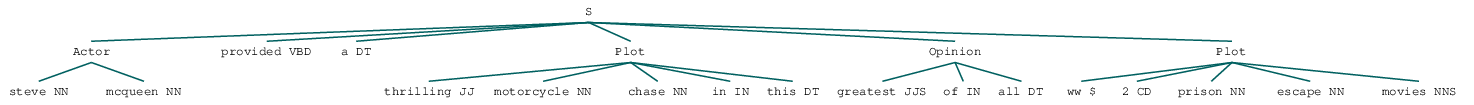

In [6]:
# example 2
next(read_corpus_to_tree("trivia10k13train.bio"))

In [7]:
# check the sentences
next(read_corpus_to_sentence("trivia10k13train.bio"))

'steve mcqueen provided a thrilling motorcycle chase in this greatest of all ww 2 prison escape movies'

Our dataset files are small, so it will not be a problem to fit the into memory. Let us see how much sentences we have.

In [8]:
%%time
# read datasets
test_samples = list(read_corpus("trivia10k13test.bio"))
train_samples = list(read_corpus("trivia10k13train.bio"))

print(f"Trivia training samples: {len(train_samples)}")
print(f"Trivia test samples: {len(test_samples)}")

Trivia training samples: 7816
Trivia test samples: 1953
CPU times: user 6.2 s, sys: 53.7 ms, total: 6.26 s
Wall time: 6.25 s


The data is ready, but before working on a model let us explore the data a little bit.

In [9]:
def get_data_list(samples):
    words = []
    pos_tags = []
    iob_tags = []
    for sentence in samples:
        for item in sentence:
            words.append(item[0][0])
            pos_tags.append(item[0][1])
            iob_tags.append(item[1])
    return words,pos_tags,iob_tags

In [10]:
train_entities = get_data_list(train_samples)
test_entities = get_data_list(test_samples)

In [11]:
train_df = pd.DataFrame({"words":train_entities[0],
                         "pos_tags":train_entities[1],
                         "iob_tags":train_entities[2]})
test_df = pd.DataFrame({"words":test_entities[0],
                         "pos_tags":test_entities[1],
                         "iob_tags":test_entities[2]})

In [12]:
print(f"Number of different iob_tags in train: {len(train_df['iob_tags'].unique().tolist())}")
print(f"Number of different iob_tags in test : {len(test_df['iob_tags'].unique().tolist())}")
print(f"Number of intersection iob_tags between train and test: {len(set(train_df['iob_tags'].unique().tolist()).intersection(set(test_df['iob_tags'].unique().tolist())))}")

Number of different iob_tags in train: 25
Number of different iob_tags in test : 25
Number of intersection iob_tags between train and test: 25


In [13]:
all_classes = train_df["iob_tags"].unique().tolist()

Train and test samples have the same number of possible iob_tags, which is good. We the model to train with all possible iob_tags.

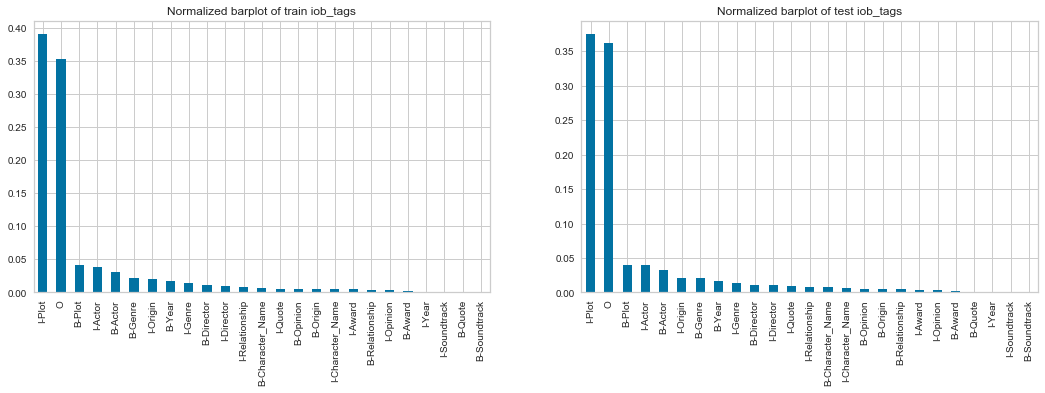

In [14]:
train_probs = train_df["iob_tags"].value_counts(normalize=True)
test_probs = test_df["iob_tags"].value_counts(normalize=True)
plt.figure(figsize=(18,5))
plt.subplot(121)
plt.title("Normalized barplot of train iob_tags")
train_probs.plot(kind='bar')
plt.xticks(rotation=90)
plt.subplot(122)
plt.title("Normalized barplot of test iob_tags")
test_probs.plot(kind='bar')
plt.xticks(rotation=90)
plt.show()

They are very similar. `I-Plot` and `O` represent about 75% of the iob_tags, so we must take care with and overfitting in these two tags.

In [15]:
print(f"Number of different pos_tags in train: {len(train_df['pos_tags'].unique().tolist())}")
print(f"Number of different pos_tags in test : {len(test_df['pos_tags'].unique().tolist())}")
print(f"Number of intersection pos_tags between train and test: {len(set(train_df['pos_tags'].unique().tolist()).intersection(set(test_df['pos_tags'].unique().tolist())))}")

Number of different pos_tags in train: 34
Number of different pos_tags in test : 32
Number of intersection pos_tags between train and test: 32


In [16]:
all_pos_tags = train_df["pos_tags"].unique().tolist()

Train set has two pos_tags more, let us pay attention in that.

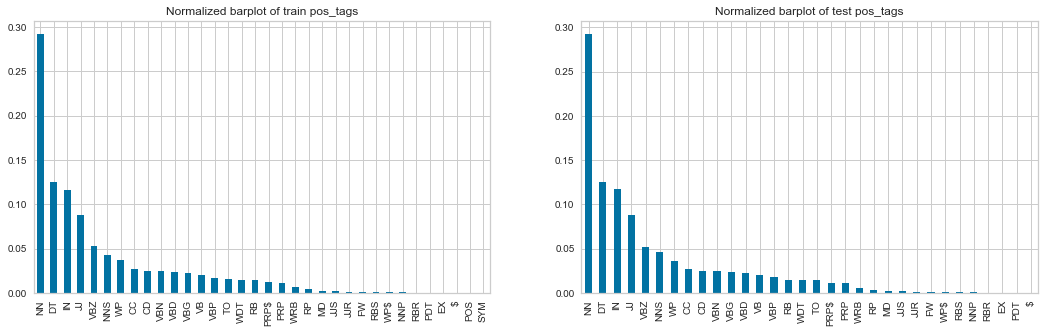

In [17]:
train_probs = train_df["pos_tags"].value_counts(normalize=True)
test_probs = test_df["pos_tags"].value_counts(normalize=True)
plt.figure(figsize=(18,5))
plt.subplot(121)
plt.title("Normalized barplot of train pos_tags")
train_probs.plot(kind='bar')
plt.xticks(rotation=90)
plt.subplot(122)
plt.title("Normalized barplot of test pos_tags")
test_probs.plot(kind='bar')
plt.xticks(rotation=90)
plt.show()

Also very similar.

Let us try another method and read data using only the pos_tags.

In [18]:
# tagged_test_data = [list(read_corpus_to_pos_tags("trivia10k13test.bio"))]
tagged_train_data = [list(read_corpus_to_pos_tags("trivia10k13train.bio"))]

In [19]:
tagged_train_data

[[[('steve', 'NN'),
   ('mcqueen', 'NN'),
   ('provided', 'VBD'),
   ('a', 'DT'),
   ('thrilling', 'JJ'),
   ('motorcycle', 'NN'),
   ('chase', 'NN'),
   ('in', 'IN'),
   ('this', 'DT'),
   ('greatest', 'JJS'),
   ('of', 'IN'),
   ('all', 'DT'),
   ('ww', '$'),
   ('2', 'CD'),
   ('prison', 'NN'),
   ('escape', 'NN'),
   ('movies', 'NNS')],
  [('liza', 'NN'),
   ('minnelli', 'NN'),
   ('and', 'CC'),
   ('joel', 'NN'),
   ('gray', 'JJ'),
   ('won', 'VBD'),
   ('oscars', 'NNS'),
   ('for', 'IN'),
   ('their', 'PRP$'),
   ('roles', 'NNS'),
   ('in', 'IN'),
   ('this', 'DT'),
   ('1972', 'CD'),
   ('movie', 'NN'),
   ('that', 'WDT'),
   ('follows', 'VBZ'),
   ('nightclub', 'JJ'),
   ('entertainers', 'NNS'),
   ('in', 'IN'),
   ('berlin', 'NN'),
   ('as', 'IN'),
   ('the', 'DT'),
   ('nazis', 'JJ'),
   ('come', 'NN'),
   ('to', 'TO'),
   ('power', 'NN')],
  [('what', 'WP'),
   ('is', 'VBZ'),
   ('that', 'DT'),
   ('tom', 'JJ'),
   ('hanks', 'NNS'),
   ('and', 'CC'),
   ('julia', 'NNS'),
   

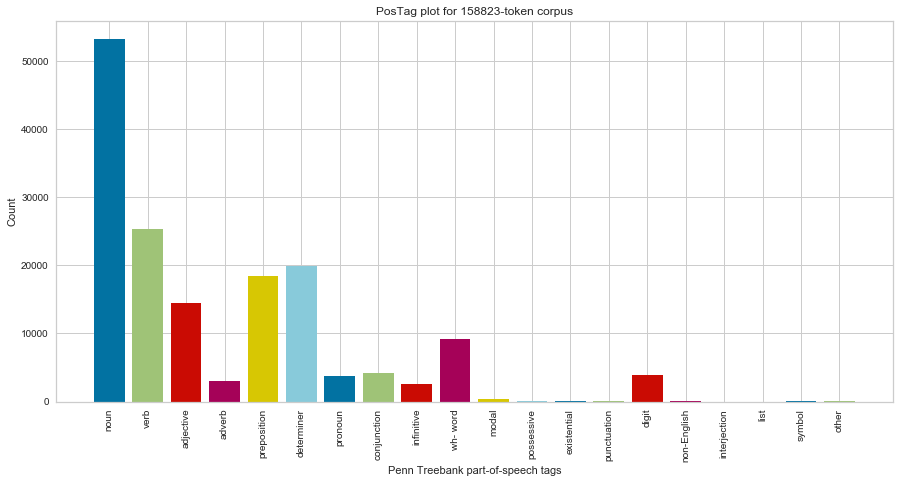

In [20]:
visualizer = PosTagVisualizer()
visualizer.fit(tagged_train_data)
visualizer.fig.set_size_inches(15, 7)
visualizer.show()

Let us check the 30 most frequent words with a quicker method.

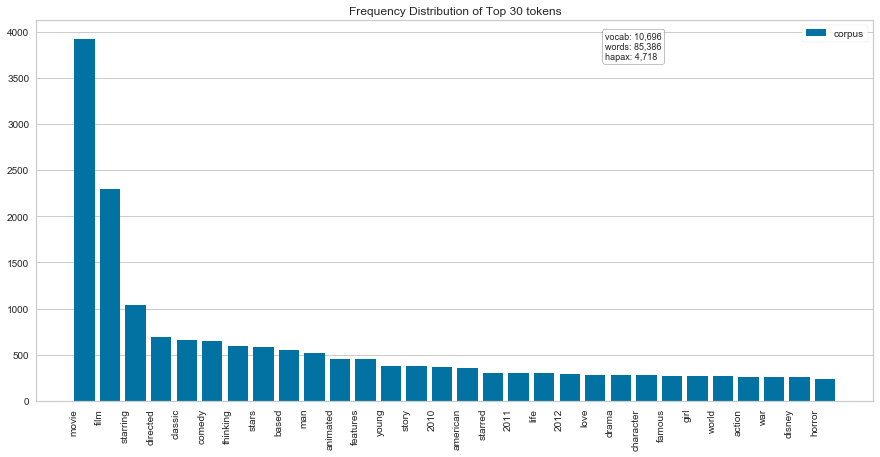

In [21]:
vectorizer = CountVectorizer(stop_words='english')
docs       = vectorizer.fit_transform(text for text in train_df['words'].values)
features   = vectorizer.get_feature_names()

visualizer = FreqDistVisualizer(features=features,n=30, orient='v')
visualizer.fit(docs)
visualizer.fig.set_size_inches(15, 7)
visualizer.show()

In our tests we can check if the model is performing good for these words.

### Build a model

We wil be using a model based on the NLTK's [`ChunkParserI`](https://www.nltk.org/api/nltk.chunk.html) and a Naive Bayes Classifier. The classifier needs a feature detector, i.e., a function which reads a sentence (a running window) and detects text patterns like: upper case characters (first letter of names); quotes, dashes, dot, interrogation marks and so on. However, when we looked at our data we saw that the text has already been processed, it is all lower case and there are no special characters (the post tagger indicated a very small number of symbols), just lower case letters and digits (word shapes).

Let us try the following function to see the number of different shape.

In [22]:
def shape(word):
    word_shape = 'other'
    if re.match('[0-9]+(\.[0-9]*)?|[0-9]*\.[0-9]+$', word):
        word_shape = 'number'
    elif re.match('\W+$', word):
        word_shape = 'punct'
    elif re.match('[A-Z][a-z]+$', word):
        word_shape = 'capitalized'
    elif re.match('[A-Z]+$', word):
        word_shape = 'uppercase'
    elif re.match('[a-z]+$', word):
        word_shape = 'lowercase'
    elif re.match('[A-Z][a-z]+[A-Z][a-z]+[A-Za-z]*$', word):
        word_shape = 'camelcase'
    elif re.match('[A-Za-z]+$', word):
        word_shape = 'mixedcase'
    elif re.match('__.+__$', word):
        word_shape = 'wildcard'
    elif re.match('[A-Za-z0-9]+\.$', word):
        word_shape = 'ending-dot'
    elif re.match('[A-Za-z0-9]+\.[A-Za-z0-9\.]+\.$', word):
        word_shape = 'abbreviation'
    elif re.match('[A-Za-z0-9]+\-[A-Za-z0-9\-]+.*$', word):
        word_shape = 'contains-hyphen'
 
    return word_shape

In [23]:
set([shape(item) for item in features])

{'lowercase', 'number'}

That confirms what we imagined. Let us keep all the shape detectors, it will not affect our model and will be useful if we decide to use it with another data. The complete feature detector also use a Stemmer and will look to: the token, one and two tokens before it and also one and two tokens after it.

In [24]:
def features_detector(tokens, index, history):
    """
    `tokens`  = a POS-tagged sentence [(w1, t1), ...]
    `index`   = the index of the token we want to extract features for
    `history` = the previous predicted IOB tags
    """
    # init the stemmer
    stemmer = SnowballStemmer('english')
 
    # Pad the sequence with placeholders
    tokens = [('[START2]', '[START2]'), ('[START1]', '[START1]')] + list(tokens) + [('[END1]', '[END1]'), ('[END2]', '[END2]')]
    history = ['[START2]', '[START1]'] + list(history)
 
    # shift the index with 2, to accommodate the padding
    index += 2
 
    word, pos = tokens[index]
    prevword, prevpos = tokens[index - 1]
    prevprevword, prevprevpos = tokens[index - 2]
    nextword, nextpos = tokens[index + 1]
    nextnextword, nextnextpos = tokens[index + 2]
    previob = history[-1]
    prevpreviob = history[-2]
 
    return {
        'word': word,
        'lemma': stemmer.stem(word),
        'pos': pos,
        'shape': shape(word),
 
        'next-word': nextword,
        'next-lemma': stemmer.stem(nextword),
        'next-pos': nextpos,
        'next-shape': shape(nextword),
 
        'next-next-word': nextnextword,
        'next-next-pos': nextnextpos,
        'next-next-lemma': stemmer.stem(nextnextword),
        'next-next-shape': shape(nextnextword),
 
        'prev-word': prevword,
        'prev-pos': prevpos,
        'prev-lemma': stemmer.stem(prevword),
        'prev-iob': previob,
        'prev-shape': shape(prevword),
 
        'prev-prev-word': prevprevword,
        'prev-prev-pos': prevprevpos,
        'prev-prev-lemma': stemmer.stem(prevprevword),
        'prev-prev-iob': prevpreviob,
        'prev-prev-shape': shape(prevprevword),
    }

### Training and evaluation

This is our model's class, the ClassifierBasedTagger is the Naive Bayes Classifier.

In [25]:
class NamedEntityModel(ChunkParserI):
    def __init__(self, train_sents, **kwargs):
        assert isinstance(train_sents, Iterable)
        self.feature_detector = features_detector
        self.tagger = ClassifierBasedTagger(
            train=train_sents,
            feature_detector=features_detector,
            **kwargs)

    def parse(self, tagged_sent):
        chunks = self.tagger.tag(tagged_sent)
        iob_triplets = [(w, t, c) for ((w, t), c) in chunks]
        return conlltags2tree(iob_triplets)

In [26]:
%%time
chunker = NamedEntityModel(train_samples)

CPU times: user 11.2 s, sys: 91.9 ms, total: 11.3 s
Wall time: 11.3 s


## Validate the model

In [27]:
%%time
# evaluation
train_score = chunker.evaluate([conlltags2tree([(w, t, iob) for (w, t), iob in iobs]) for iobs in train_samples])
test_score  = chunker.evaluate([conlltags2tree([(w, t, iob) for (w, t), iob in iobs]) for iobs in test_samples])
print(f"Train accuracy: {train_score.accuracy():.1%}")
print(f"Test accuracy: {test_score.accuracy():.1%}")

Train accuracy: 84.3%
Test accuracy: 80.1%
CPU times: user 1min 43s, sys: 5.78 ms, total: 1min 43s
Wall time: 1min 43s


It does not look bad, but accuracy is a misleading metric. Let us build another scorer.

In [28]:
def chunk_scorer(samples):
    chunkscore = ChunkScore()           
    for correct in [conlltags2tree([(w, t, iob) for (w, t), iob in iobs]) for iobs in samples]:   
        guess = chunker.parse(correct.leaves())   
        chunkscore.score(correct, guess)
    return chunkscore

In [29]:
%%time
train_chunk_scorer = chunk_scorer(train_samples)
test_chunk_scorer = chunk_scorer(test_samples)

CPU times: user 1min 43s, sys: 35.2 ms, total: 1min 43s
Wall time: 1min 43s


In [30]:
print(f"""Train dataset\nAccuracy: {train_chunk_scorer.accuracy():.2f}\nPrecision: {train_chunk_scorer.precision():.2f}
Recall:    {train_chunk_scorer.recall():.2f}\nF Measure: {train_chunk_scorer.f_measure():.2f}\n""")
print(f"""Test dataset\nAccuracy: {test_chunk_scorer.accuracy():.2f}\nPrecision: {test_chunk_scorer.precision():.2f}
Recall:    {test_chunk_scorer.recall():.2f}\nF Measure: {test_chunk_scorer.f_measure():.2f}""")

Train dataset
Accuracy: 0.84
Precision: 0.58
Recall:    0.65
F Measure: 0.61

Test dataset
Accuracy: 0.80
Precision: 0.51
Recall:    0.59
F Measure: 0.55


It may not looks good, but if we remember that there are 34 different `pos_tags` a random choice would be correct about 3% of the time.

Now let us take a look in some of the incorrect classifications.

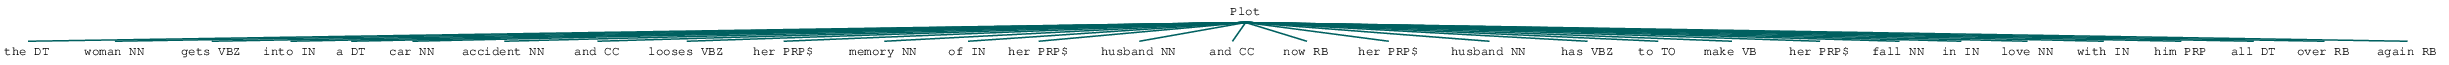

In [31]:
train_chunk_scorer.incorrect()[0]

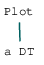

In [32]:
train_chunk_scorer.incorrect()[1]

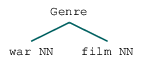

In [33]:
train_chunk_scorer.incorrect()[2]

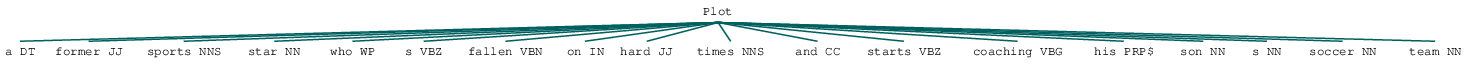

In [34]:
train_chunk_scorer.incorrect()[3]

Some of them does not look exactly wrong, it is just a hard problem to solve. For a first solution looks good.

## Look for some data with similar context and use it to evaluate the model

We will be using the opentdb API to request some sentences and apply our model to them. This API is a good fit to us because it does not require authentication. We need a function which receives the sentence as input and gives us the three as output and some functions to deal with text normalization.

In [35]:
def classify_sentence(sentence,model=chunker):
    return model.parse(pos_tag(word_tokenize(sentence)))

unescape_dict = {
     "&amp;":"&",
     "&quot;":'',
     "&apos;":"'",
     "&gt;":">",
     "&lt;":"<",
     "&#039;":"'",
     ",":"",
     "`":"",
     ")":"",
     "'":""
     }

separator_string = re.compile(r'\s+')

def remove_accents(text):
    nfkd_form = unicodedata.normalize('NFKD', text)
    return u"".join([c for c in nfkd_form if not unicodedata.combining(c)])

def lowercase(text):
    return text.lower()
    
def remove_symbols(text):
    symbols = re.compile(r'((^| )(?<!\w)[^\wáíúéóàâêôãõçÁÍÚÉÓÀÂÊÔÃÕÇ])|([^\wáíúéóàâêôãõçÁÍÚÉÓÀÂÊÔÃÕÇ](?!\w)($| ))')
    return symbols.sub(' ', text)
    
def clean_text(text):
    unscaped_text = unescape(text,unescape_dict)
    low_cased = lowercase(unscaped_text)
    no_accents = remove_accents(low_cased)
    no_symbols = remove_symbols(no_accents).strip()
    return ' '.join(separator_string.split(no_symbols))

def request_questions():
    """
    This url indicates the amount of requests (10), the questions category (11 = movies), difficulty (easy) and type (multiple)
    """
    msg = requests.get(url="https://opentdb.com/api.php?amount=10&category=11&difficulty=easy&type=multiple").json()
    return [clean_text(item["question"]) for item in msg["results"]]

def classify_opentdb_questions():
    question_classification_list = []
    for question in request_questions():
        question_classification_list.append([question,classify_sentence(question)])
    return question_classification_list

Let us check some random sentences:

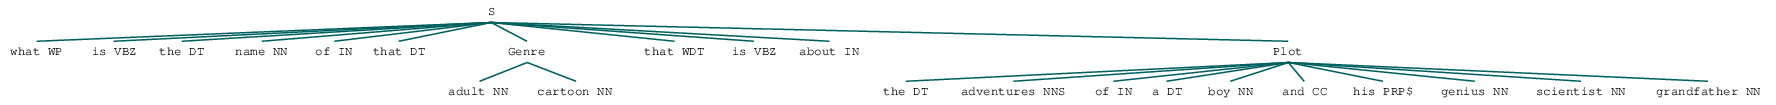

In [36]:
classify_sentence("what is the name of that adult cartoon that is about the adventures of a boy and his genius scientist grandfather")

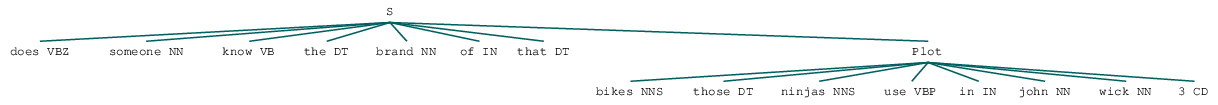

In [37]:
classify_sentence("does someone know the brand of that bikes those ninjas use in john wick 3")

Now let us try the opentdb questions

In [38]:
question_classification_list = classify_opentdb_questions()

who played deputy marshal samuel gerard in the 1993 film the fugitive


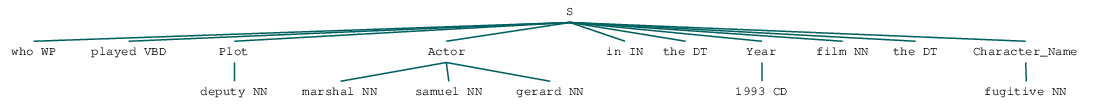

In [39]:
print(question_classification_list[0][0])
question_classification_list[0][1]

who starred in the film 1973 movie enter the dragon


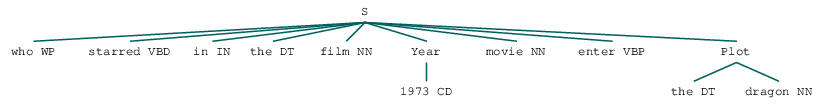

In [40]:
print(question_classification_list[1][0])
question_classification_list[1][1]

what was dorothys surname in the wizard of oz


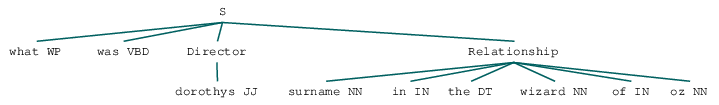

In [41]:
print(question_classification_list[2][0])
question_classification_list[2][1]

this movie contains the quote nobody puts baby in a corner


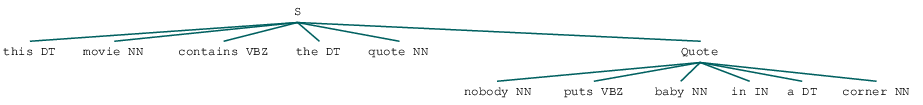

In [42]:
print(question_classification_list[3][0])
question_classification_list[3][1]

## Conclusions

The model does a decent job for a first try. A good improvement could be using spaCy library, which has a lot of good methods implemented in it or we could be more audacious and change the Naive Bayes Classifier by a neural network (RNN ou LSTM) or even try the state-of-art models like BERT and GPT-3. I also tried increasing the range of padded tokens from 2 to 3, but it did not improve.